In [10]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [11]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [12]:
from quadratic_weighted_kappa import quadratic_weighted_kappa

In [13]:
xgb.__version__,xgb.__file__

('0.6', '../third/xgboost/python-package/build/lib/xgboost/__init__.pyc')

In [1]:
import fastparquet
%time df=fastparquet.ParquetFile("../input/train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 1.59 s, sys: 3.04 s, total: 4.63 s
Wall time: 4.63 s


In [2]:
df.shape

(6582476, 54)

In [3]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582476 entries, 0 to 15203954
Columns: 54 entries, market to id_count
dtypes: float32(53), int8(1)
memory usage: 1.4 GB


In [4]:
(df.index<10000000).sum(),(df.target<0).sum()

(1378521, 1378521)

In [5]:
testx=df[df.index<10000000].drop('target',axis=1)
testx.shape

(1378521, 53)

In [6]:
df=df[df.index>=10000000]

In [7]:
df.shape

(5203955, 54)

In [8]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203955 entries, 10000000 to 15203954
Columns: 54 entries, market to id_count
dtypes: float32(53), int8(1)
memory usage: 1.1 GB


In [14]:
df=df.loc[np.random.permutation(df.index)]

In [15]:
import gc
gc.collect()

512

In [16]:
df.head()

market       f_0       f_1       f_2       f_3       f_4  \
id                                                                     
10041888  4.600824  4.084971  4.589514  4.576220  0.663118  0.525919   
14122229  4.389747  4.786207  4.715542  4.622002  2.614370  1.677439   
14481653  4.753313  4.786207  4.715542  4.622002  0.100615  0.090367   
13543992  5.310967  4.458380  4.589514  4.610031  0.000000  1.710523   
11766363  4.389747  4.682021  4.589514  4.622002  0.393716  0.345395   

               f_5  f_6       f_7       f_8    ...     latest_target   count  \
id                                             ...                             
10041888  2.859509  0.0  4.336779  1.001795    ...               3.0     2.0   
14122229  5.681114  0.0  4.717993  1.442412    ...               7.0     2.0   
14481653  2.081243  0.0  3.388240  1.241753    ...           -9999.0 -9999.0   
13543992  5.681114  0.0  4.658438  1.001795    ...           -9999.0 -9999.0   
11766363  2.279448  0.0  4.160428  1.026783    ...               4.0     1.0   

                 freq  latest3_mean  changed_count  latest2_change  \
id                                                                   
10041888     0.333333       -9999.0            1.0             1.0   
14122229     1.000000       -9999.0            0.0             0.0   
14481653 -9999.000000       -9999.0        -9999.0         -9999.0   
13543992 -9999.000000       -9999.0        -9999.0         -9999.0   
11766363     1.000000       -9999.0            0.0         -9999.0   

          latest2_mean  mkt_mean  mkt_count  id_count  
id                                                     
10041888          25.0      2.75        2.0       5.0  
14122229          70.0      7.00        1.0       2.0  
14481653       -9999.0  -9999.00    -9999.0   -9999.0  
13543992       -9999.0  -9999.00    -9999.0   -9999.0  
11766363       -9999.0      3.30        2.0       6.0  

[5 rows x 54 columns]

In [17]:
trainx=df.drop(['target'],axis=1)
trainy=df['target']

In [18]:
trainx.shape

(5203955, 53)

In [19]:
5203954*.8

4163163.2

In [20]:
split = 4163163
x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(testx)




Building DMatrix...


In [21]:
x_train.shape,x_valid.shape

((4163163, 53), (1040792, 53))

In [2]:
import numpy as np
from numba import jit 

@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    w = np.zeros((max_rat + 1, max_rat + 1))
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            w[i, j] = (i - j) * (i - j)/ (max_rat * max_rat)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for i, j in zip(a1, a2):
        hist1[i] += 1
        hist2[j] += 1
        o +=  w[i, j]

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * w[i, j]

    e = e / a1.shape[0]

    return 1 - o / e

In [22]:
print('Training ...')

params = {}
params['eta'] = 0.2
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['max_depth'] = 8
params['nthread']=8
params['silent'] = 1
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
%time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40)


Training ...
[0]	train-rmse:4.20833	valid-rmse:4.20541
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[40]	train-rmse:1.86258	valid-rmse:1.87533
[80]	train-rmse:1.8476	valid-rmse:1.87189
[120]	train-rmse:1.83628	valid-rmse:1.87067
[160]	train-rmse:1.82669	valid-rmse:1.87031
[200]	train-rmse:1.81795	valid-rmse:1.86994
Stopping. Best iteration:
[185]	train-rmse:1.82087	valid-rmse:1.86989

CPU times: user 20min 57s, sys: 16.3 s, total: 21min 13s
Wall time: 2min 48s


In [57]:
pd.Series(clf.get_fscore()).sort_values()

f_34               128
changed_count      133
count              155
f_29               174
f_37               232
f_9                241
f_16               258
f_39               278
f_10               280
f_1                310
f_2                335
freq               372
f_6                378
f_24               389
f_31               412
f_20               420
latest3_mean       447
mkt_count          505
f_23               732
age                760
latest2_mean       779
f_38               804
f_41               847
latest2_change     875
f_25               911
f_40               943
f_32               959
f_33               982
id_count           990
f_5               1022
f_30              1068
f_22              1071
f_27              1120
f_28              1157
f_0               1200
f_12              1223
f_26              1235
f_35              1250
f_17              1298
f_14              1371
f_4               1393
f_36              1510
latest_target     1526
f_18       

In [23]:
def scale_pred(y_true, y_pred):
    B=np.mean((y_true-y_true.mean())**2)
    C=np.mean((y_pred-y_pred.mean())**2)
    A=np.mean((y_true-y_pred)**2)
    
    print A,B,C, (C-A+B)/(C+B)
    
    b=np.arange(-1,1.3,0.01)
    bb=(b*(C-A)+B)/(C+b**2*B)
    print max(bb)
    plt.plot(b,bb)
    return (B/(A-C))
def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

In [24]:
pred=clf.predict(d_valid)

In [25]:
lst=[]
for s in np.arange(1.25,1.35,0.01):
    a= s, quadratic_weighted_kappa(y_valid,clip_pred((pred-pred.mean())*s+pred.mean()))
    print a
    lst.append(a)

(1.25, 0.7728946336380992)
(1.26, 0.7730647036848839)
(1.27, 0.7731706270334121)
(1.28, 0.7732078765373636)
(1.29, 0.7732220523756655)
(1.3, 0.7731795269095612)
(1.3100000000000001, 0.7730849404950475)
(1.3200000000000001, 0.7729910577157908)
(1.3300000000000001, 0.7728890624342494)
(1.3400000000000001, 0.7726567307679794)
(1.3500000000000001, 0.7724361421778853)


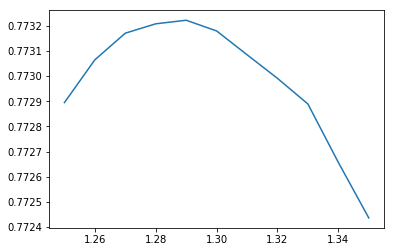

In [26]:
plt.plot(np.array(lst).T[0],np.array(lst).T[1])

In [27]:
pred=clip_pred(pred)

In [28]:
quadratic_weighted_kappa(y_valid,pred)

0.7496282226546537

In [29]:
raw_pred=clf.predict(d_train)

In [30]:
pred=clip_pred(raw_pred)
quadratic_weighted_kappa(y_train,pred)

0.7654559556845046

In [31]:
for s in np.arange(1.1,1.41,0.05):
    pred=(raw_pred-raw_pred.mean())*s+raw_pred.mean()
    pred=clip_pred(pred)
    print s, np.round(quadratic_weighted_kappa(y_train,pred),3)

1.1 0.78
1.15 0.784
1.2 0.787
1.25 0.789
1.3 0.789
1.35 0.788
1.4 0.787


# test pred

In [32]:
pred=clip_pred(clf.predict(d_test))

In [33]:
pred.shape

(1378521,)

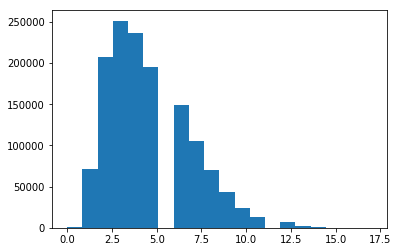

In [34]:
plt.hist(pred,bins=20);

In [35]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

/home/spark/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [36]:
sample_sub.shape

(1378521, 1)

In [37]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [38]:
this_sub=this_sub.loc[sample_sub.index]

In [39]:
this_sub.isnull().sum()

target    0
dtype: int64

In [40]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [41]:
make_submission(this_sub,"../submission/simple_xgb_combined.csv")

rm: cannot remove ‘../submission/simple_xgb_combined.csv.7z’: No such file or directory


# test pred2

In [42]:
pred=(clf.predict(d_test))

In [43]:
pred.shape

(1378521,)

In [44]:
pred.mean()

4.5412698

In [45]:
pred=(pred-pred.mean())*1.29+pred.mean()

In [46]:
pred=clip_pred(pred)

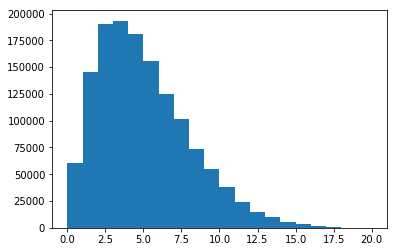

In [47]:
plt.hist(pred,bins=20);

In [48]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

In [49]:
sample_sub.shape

(1378521, 1)

In [50]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [51]:
this_sub=this_sub.loc[sample_sub.index]

In [52]:
this_sub.isnull().sum()

target    0
dtype: int64

In [53]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [54]:
make_submission(this_sub,"../submission/simple_xgb_combined_s1.29.csv")

rm: cannot remove ‘../submission/simple_xgb_combined_s1.29.csv.7z’: No such file or directory
